# Import library and load models

In [1]:
!pip install transformers[torch]
!pip install gradio validators
!pip install plotly fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB

In [2]:
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from bs4 import BeautifulSoup
import requests
import validators
import psycopg2
import math
import torch
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
### fine-tuned models
#News Classification
tc_checkpoint = "tamhuynh27/ernie-base-2.0-en-agnews"
news_classifier = pipeline("text-classification", model=tc_checkpoint)

#NER
ner_checkpoint = "hoangkhanhnghi/electra-finetuned-ner-task"
token_classifier = pipeline("token-classification", model=ner_checkpoint, aggregation_strategy="simple")

#summarization
tokenizer = AutoTokenizer.from_pretrained("emonty777/t5-small-finetuned-xsum")
summary_model = AutoModelForSeq2SeqLM.from_pretrained("emonty777/t5-small-finetuned-xsum")

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# AWS RDS connection

In [4]:
# function to connect to database
def create_connection():
    """Create and return a connection to the database"""
    conn_params = {
        "host": "news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
        "port": 5432,
        "user": "postgres",
        "password": "sjsu298postgres",
        "database": "newsDB"
    }
    try:
        conn = psycopg2.connect(**conn_params)
        print("Connection successful")
        return conn
    except Exception as e:
        print(f"Unable to connect to the database. Error: {e}")
        return None


# Task Functions

NER

In [5]:
def merge_similar_entities(entity_list, threshold=45):
    unique_entities = []
    for entity in entity_list:
        if not any(fuzz.ratio(entity, unique_entity) > threshold for unique_entity in unique_entities):
            unique_entities.append(entity)
    return unique_entities

def chunk_content(content, chunk_size=512):
    return [content[i:i + chunk_size] for i in range(0, len(content), chunk_size)]

def display_ner(content, chunk_size=512):
    start_time = time.time()
    chunks = chunk_content(content, chunk_size)
    loc_list = []
    per_list = []
    org_list = []

    for chunk in chunks:
        ner_res = token_classifier(chunk)
        for i in ner_res:
            gr = i['entity_group']
            w = i['word']
            score = i['score']

            if score < 0.9:
                pass
            else:
                if (gr == 'LOC') & (w not in loc_list): loc_list.append(w)
                elif (gr == 'PER') & (w not in per_list): per_list.append(w)
                elif (gr == 'ORG') & (w not in org_list): org_list.append(w)

    # Merge similar entities / how we filter now
    loc_list = merge_similar_entities(loc_list)
    per_list = merge_similar_entities(per_list)
    org_list = merge_similar_entities(org_list)

    print("loc: ",loc_list)
    print("per: ", per_list)
    print("org: ", org_list)

    loc_url = ['<a href="https://en.wikipedia.org/wiki/' + loc.replace(" ", "_") + '" target="_blank">' + loc + '</a>' for loc in loc_list]
    per_url = ['<a href="https://en.wikipedia.org/wiki/' + per.replace(" ", "_") + '" target="_blank">' + per + '</a>' for per in per_list]
    org_url = ['<a href="https://en.wikipedia.org/wiki/' + org.replace(" ", "_") + '" target="_blank">' + org + '</a>' for org in org_list]

    result_html = "<div><strong>Named Entity Recognition</strong> " + "<br><t><i>Location</i>: " + ", ".join(loc_url) + \
                  "<br><t><i>Person</i>: " + ", ".join(per_url) + \
                  "<br><t><i>Organization</i>: " + ", ".join(org_url) + "</div>"

    execution_time = time.time() - start_time
    return loc_list, per_list, org_list, result_html, execution_time


Summarization

In [6]:
def summarization(article):
    start_time = time.time()
    input_ids = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=2048)
    summary_ids = summary_model.generate(
        input_ids,
        num_beams=7,  # Increase the number of beams
        no_repeat_ngram_size=3,  # Increase the n-gram size
        min_length=70,
        max_length=100,
        length_penalty=0.8,  # Introduce length penalty
        temperature=0.7,  # Introduce temperature
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    execution_time = time.time() - start_time
    return summary, execution_time

Classification

In [7]:
def classify_text(text):
    start_time = time.time()
    result = news_classifier(text)
    execution_time = time.time() - start_time
    return result, execution_time

# System Implementation

In [8]:
def get_prediction(url_input):
    news_content = " "
    title = "Unknown"
    text = """ """

    try:
        response = requests.get(url_input)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            headlines = soup.find_all("h1")
            title = headlines[0].text.strip()

            paragraphs = soup.find_all("p")
            for p in paragraphs:
                news_content += p.get_text() + ". "

        ats, ats_exe = summarization(news_content)
        loc_list, per_list, org_list, ner_html, ner_exe = display_ner(news_content)
        tc, tc_exe = classify_text(ats)
        text = news_content

    except requests.exceptions.RequestException as e:
        print("Error occurred during the request:", e)

    tc_output = tc[0]['label']
    ats_output = ats

    try:
         # Database interaction
         conn = psycopg2.connect(
             host="news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
             port="5432",
             dbname="newsDB",
             user="postgres",
             password="sjsu298postgres"
         )
         c = conn.cursor()

         # Insert into raw_article and get the article_id
         c.execute("INSERT INTO raw_article (article_url, article_title, news_content) VALUES (%s, %s, %s) RETURNING article_id",
                   (url_input, title, news_content))
         article_id = c.fetchone()[0]  # Get the article_id of the inserted row

         # Insert into article_category_and_summary
         c.execute("INSERT INTO article_category_and_summary (article_id, article_category, article_summary) VALUES (%s, %s, %s)",
                   (article_id, tc_output, ats_output))
         # Insert into execution_times
         c.execute("INSERT INTO execution_times (article_id, classification_time, ner_time, summarization_time) VALUES (%s, %s, %s, %s)",
                    (article_id, tc_exe, ner_exe, ats_exe))

         # Inserting the unique entities into the database with error handling
         for loc in loc_list:
             try:
                 c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                           (article_id, 'LOC', loc))
             except Exception as e:
                 print(f"Error occurred while inserting LOC entity: {e}")
                 conn.rollback()  # Rollback the current transaction if an error occurred

         for per in per_list:
             try:
                 c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                           (article_id, 'PER', per))
             except Exception as e:
                 print(f"Error occurred while inserting PER entity: {e}")
                 conn.rollback()  # Rollback the current transaction if an error occurred

         for org in org_list:
             try:
                 c.execute("INSERT INTO article_ner (article_id, ner_type, entity_type) VALUES (%s, %s, %s)",
                           (article_id, 'ORG', org))
             except Exception as e:
                 print(f"Error occurred while inserting ORG entity: {e}")
                 conn.rollback()  # Rollback the current transaction if an error occurred


         # Commit the changes and close the connection
         conn.commit()
         c.close()
         conn.close()

    except Exception as e:
         print(f"An error occurred: {e}")
         if conn:
             conn.rollback()

    return (title, tc_output, ner_html, ats_output, ats_exe, ner_exe, tc_exe)


inputs = gr.Textbox(label='Article URL')
outputs = gr.Textbox()

# Gr.Interface setup
gr.Interface(fn=get_prediction, inputs=inputs,
             outputs=[gr.Textbox(label="News Title"),
                      gr.Textbox(label="News Classification"),
                      gr.HTML(),
                      gr.Textbox(label="Abstractive Text Summarization")],
             title="Analyzing News Articles Using NLP Techniques",
             description="Input News Article URL to Get Outputs",
             theme=gr.themes.Soft(),
             live=False
             ).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7f91566ecaf531766f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Database Creation

In [ ]:
# Code to edit database
# Code to create database

#import psycopg2
#from psycopg2 import sql

# # Database connection parameters
#db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
#}


# # SQL statements to create the tables
# create_raw_article_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS raw_article (
#         article_id SERIAL PRIMARY KEY,
#         article_url TEXT,
#         article_title TEXT,
#         news_content TEXT,
#         timestamp TIMESTAMPTZ DEFAULT CURRENT_TIMESTAMP
#     )
# """)

# create_article_category_and_summary_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS article_category_and_summary (
#         article_id INTEGER PRIMARY KEY REFERENCES raw_article(article_id),
#         article_category TEXT,
#         article_summary TEXT
#     )
# """)

# create_article_ner_table = sql.SQL("""
#     CREATE TABLE IF NOT EXISTS article_ner (
#         ner_id SERIAL PRIMARY KEY,
#         article_id INTEGER REFERENCES raw_article(article_id),
#         ner_type TEXT,
#         entity_type TEXT
#     )
# """)
#create_execution_table = sql.SQL("""
#      CREATE TABLE execution_times (
#          article_id INTEGER REFERENCES raw_article(article_id),
#         classification_time FLOAT,
#         ner_time FLOAT,
#         summarization_time FLOAT
#    );
#""")

#try:
#     # Connect to the database
#    conn = psycopg2.connect(**db_params)
#    c = conn.cursor()

#     # Execute SQL statements to create the tables
#     c.execute(create_raw_article_table)
#     c.execute(create_article_category_and_summary_table)
#     c.execute(create_article_ner_table)
#    c.execute(create_execution_table)
#     # Commit the transaction
#    conn.commit()

#     # Close the cursor and the connection
#    c.close()
#    conn.close()

# except Exception as e:
#    print(f"An error occurred: {e}")


# Database and Table Display

In [ ]:
#----------------------------------- DISPLAYS THE WHOLE DATABASE -----------------------------------

import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format

# Database connection parameters
# db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
# }

# SQL SELECT statement
select_statement = """
    SELECT
        ra.article_id, ra.article_url, ra.article_title, ra.news_content, ra.timestamp,
        acs.article_category, acs.article_summary,
        an.ner_id, an.ner_type, an.entity_type
    FROM
        raw_article ra
    JOIN
        article_category_and_summary acs ON ra.article_id = acs.article_id
    LEFT JOIN
        article_ner an ON ra.article_id = an.article_id
    ORDER BY ra.timestamp DESC
"""

try:
    # Connect to the database
    conn = create_connection()

    # Fetch the results into a DataFrame
    df = pd.read_sql(select_statement, con=conn)

    # Display the DataFrame in a more readable format
    display(df)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-10-7907ae2fbf4c>:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(select_statement, con=conn)


,article_id,article_url,article_title,news_content,timestamp,article_category,article_summary,ner_id,ner_type,entity_type
0,92,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 03:02:48.813512+00:00,Business,The U.S. Federal Reserve has released a new in...,1740.0,LOC,palm beach
1,92,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 03:02:48.813512+00:00,Business,The U.S. Federal Reserve has released a new in...,1785.0,ORG,warner bros. discovery
2,92,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 03:02:48.813512+00:00,Business,The U.S. Federal Reserve has released a new in...,1738.0,LOC,middle east
3,92,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 03:02:48.813512+00:00,Business,The U.S. Federal Reserve has released a new in...,1784.0,ORG,cable news network
4,92,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 03:02:48.813512+00:00,Business,The U.S. Federal Reserve has released a new in...,1783.0,ORG,copp clark limited
...,...,...,...,...,...,...,...,...,...,...
1779,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00,Entertainment,Writers Guild of America has ratified a deal w...,6.0,ORG,WGA
1780,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00,Entertainment,Writers Guild of America has ratified a deal w...,5.0,LOC,Hollywood
1781,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00,Entertainment,Writers Guild of America has ratified a deal w...,4.0,ORG,Writers Guild of America
1782,11,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:38:44.792324+00:00,Entertainment,Writers Guild of America has ratified a deal w...,NaN,None,None


In [ ]:
#----------------------------------- DISPLAYS THE RAW ARTICLE TABLE -----------------------------------


import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format

# Database connection parameters
# db_params = {
#     'dbname': 'newsDB',
#     'user': 'postgres',
#     'password': 'sjsu298postgres',
#     'host': 'news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com',
#     'port': '5432'
# }

# SQL statements
select_raw_article = "SELECT * FROM raw_article"

try:
    # Connect to the database
    conn = create_connection()

    # Execute the first SQL statement and display the results
    df_raw_article = pd.read_sql(select_raw_article, con=conn)
    display(df_raw_article)


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-11-989245da3230>:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw_article = pd.read_sql(select_raw_article, con=conn)


,article_id,article_url,article_title,news_content,timestamp
0,10,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:36:32.742100+00:00
1,11,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:38:44.792324+00:00
2,14,https://www.cnn.com/2023/09/24/business/wga-st...,Writers Guild and studios reach tentative deal...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-09-25 04:49:28.455779+00:00
3,15,https://www.cnn.com/2023/09/24/entertainment/t...,Taylor Swift cheers on Travis Kelce at Kansas ...,"\n It’s a love story, perhaps, for NFL t...",2023-09-25 04:59:17.459335+00:00
4,16,https://www.cnn.com/2023/09/24/politics/cassid...,Cassidy Hutchinson defends herself in first po...,"\nCassidy Hutchinson, the former Trump White ...",2023-09-25 05:13:29.018312+00:00
...,...,...,...,...,...
69,88,https://www.cnn.com/middleeast/live-news/israe...,"November 3, 2023 Israel-Hamas war news","By Kathleen Magramo, Lauren Said-Moorhouse, L...",2023-11-06 06:23:00.976782+00:00
70,89,https://www.cnn.com/2023/11/12/business/marvel...,‘The Marvels’ struggles at box office on openi...,Markets \n\n\n\nFear & Greed Index \n\n\n\n\n...,2023-11-13 02:20:28.771911+00:00
71,90,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 02:25:09.162995+00:00
72,91,https://www.cnn.com/2023/11/12/economy/stocks-...,The Fed is terrified Americans could get used ...,Markets \n\n\n. Fear & Greed Index \n\n\n. \n...,2023-11-13 02:37:10.567912+00:00


In [ ]:
#----------------------------------- DISPLAYS THE aRTICLE CATEGORY AND SUMMARY TABLE -----------------------------------

import pandas as pd
import psycopg2
from IPython.display import display  # For displaying the DataFrame in a nice format


# SQL statements
select_article_category_and_summary = "SELECT * FROM article_category_and_summary"


try:
    # Connect to the database
    conn = create_connection()

    # Execute the second SQL statement and display the results
    df_article_category_and_summary = pd.read_sql(select_article_category_and_summary, con=conn)
    display(df_article_category_and_summary)


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-12-301331925f54>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_article_category_and_summary = pd.read_sql(select_article_category_and_summary, con=conn)


,article_id,article_category,article_summary
0,10,Entertainment,Writers Guild of America has ratified a deal w...
1,11,Entertainment,Writers Guild of America has ratified a deal w...
2,14,Entertainment,Writers Guild of America has ratified a deal w...
3,15,Sports,"Jason Kelce has said he was a ""little bit hurt..."
4,16,Entertainment,Former White House aide Cassidy Hutchinson has...
...,...,...,...
69,87,Entertainment,Amazon’s “The Boys” spinoff “Gen V” and “Invin...
70,88,World,Israel has urged the US to enact a new phase o...
71,89,Entertainment,The Marvel Cinematic Universe has raked in his...
72,90,Business,The U.S. Federal Reserve has released a new in...


In [ ]:
#----------------------------------- DISPLAYS ARTICLE NER TABLE -----------------------------------

# SQL statements
select_article_ner = "SELECT * FROM article_ner"

try:
    # Connect to the database
    conn = create_connection()


    # Execute the third SQL statement and display the results
    df_article_ner = pd.read_sql(select_article_ner, con=conn)
    display(df_article_ner)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-13-091faf200184>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_article_ner = pd.read_sql(select_article_ner, con=conn)


,ner_id,article_id,ner_type,entity_type
0,1248,66,LOC,Mexico
1,1249,66,LOC,Zacatecas
2,1250,66,LOC,Malpaso
3,4,14,ORG,Writers Guild of America
4,5,14,LOC,Hollywood
...,...,...,...,...
1777,1781,92,ORG,dow jones trademark holdings llc
1778,1782,92,ORG,##arb
1779,1783,92,ORG,copp clark limited
1780,1784,92,ORG,cable news network


In [ ]:
#----------------------------------- DISPLAYS EXECUTION TABLE -----------------------------------

# SQL statements
select_exe_table = "SELECT * FROM execution_times"

try:
    # Connect to the database
    conn = create_connection()


    # Execute the third SQL statement and display the results
    df_exe_table = pd.read_sql(select_exe_table, con=conn)
    display(df_exe_table)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the connection
    if conn:
        conn.close()


Connection successful


<ipython-input-14-42dbe0092b42>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_exe_table = pd.read_sql(select_exe_table, con=conn)


,article_id,classification_time,ner_time,summarization_time
0,74,0.273702,3.227790,12.956416
1,75,0.291723,2.588286,11.333945
2,76,0.316841,2.154046,8.410232
3,77,0.284414,2.282001,10.890079
4,78,0.434787,2.619441,7.907824
5,79,0.425477,4.477119,11.430696
6,84,0.279232,7.522642,17.000388
7,86,0.552027,3.422284,12.600062
8,87,0.797541,5.087669,14.590426
9,88,0.589203,9.858858,20.208689


# Data Visualizations

Connection successful


<ipython-input-15-e75ce6438cb3>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


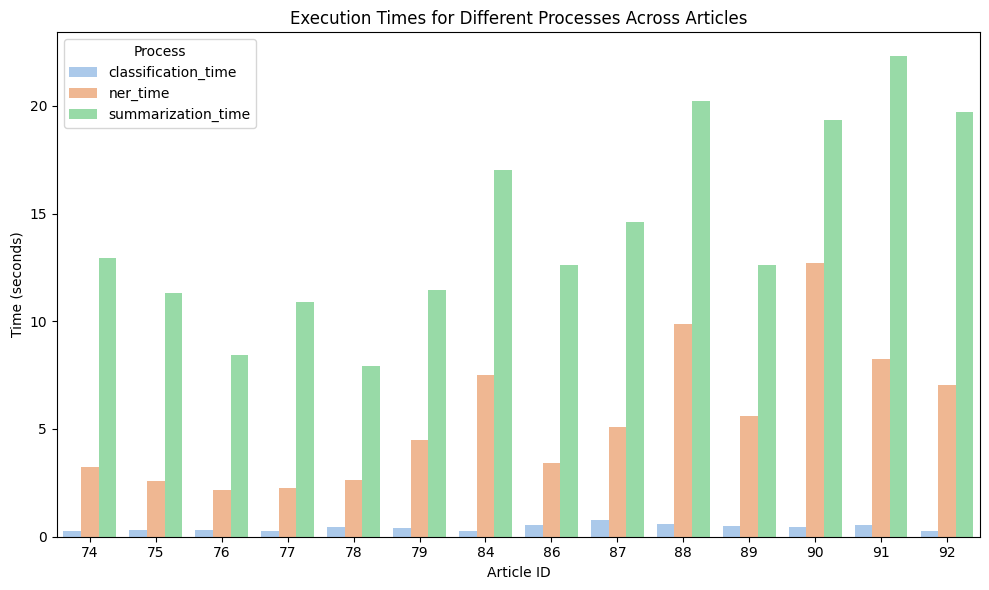

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sql = "SELECT * FROM execution_times"
conn = create_connection()
df = pd.read_sql(sql, con=conn)

conn.close()

# Melting the DataFrame to make it suitable for sns.barplot
df_melted = df.melt(id_vars="article_id", var_name="Process", value_name="Time")

plt.figure(figsize=(10,6))
sns.barplot(x="article_id", y="Time", hue="Process", data=df_melted, palette="pastel")
plt.title('Execution Times for Different Processes Across Articles')
plt.xlabel('Article ID')
plt.ylabel('Time (seconds)')
plt.legend(title='Process')
plt.tight_layout()
plt.show()



Connection successful


<ipython-input-16-b9f7e2c2b2ea>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


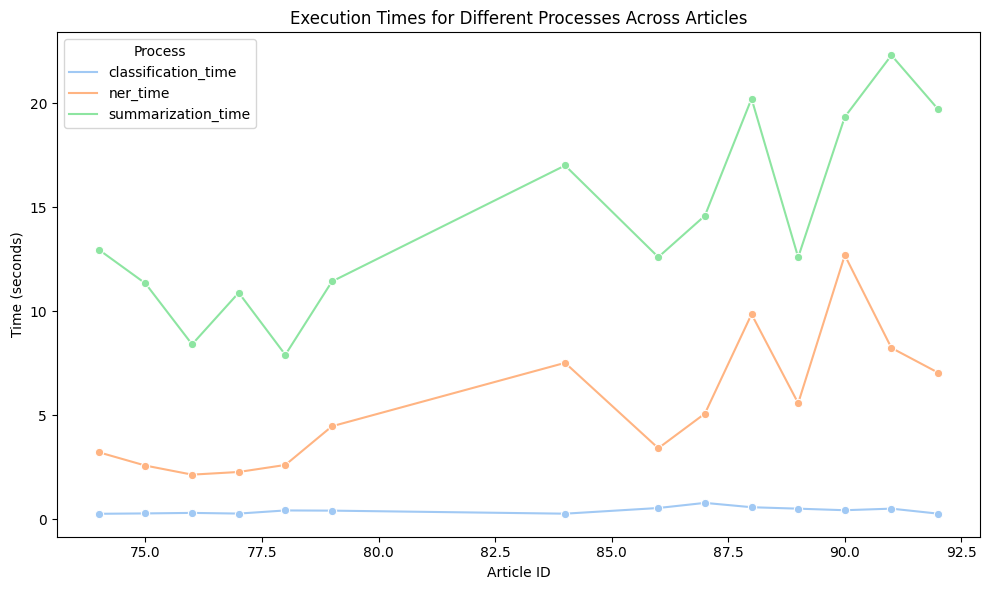

In [ ]:
sql = "SELECT * FROM execution_times"
conn = create_connection()
df = pd.read_sql(sql, con=conn)
conn.close()

# Melting the DataFrame to make it suitable for sns.lineplot
df_melted = df.melt(id_vars="article_id", var_name="Process", value_name="Time")

plt.figure(figsize=(10,6))
sns.lineplot(x="article_id", y="Time", hue="Process", data=df_melted, palette="pastel", marker="o")
plt.title('Execution Times for Different Processes Across Articles')
plt.xlabel('Article ID')
plt.ylabel('Time (seconds)')
plt.legend(title='Process')
plt.tight_layout()
plt.show()


Connection successful


<ipython-input-17-074c5f3018f2>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


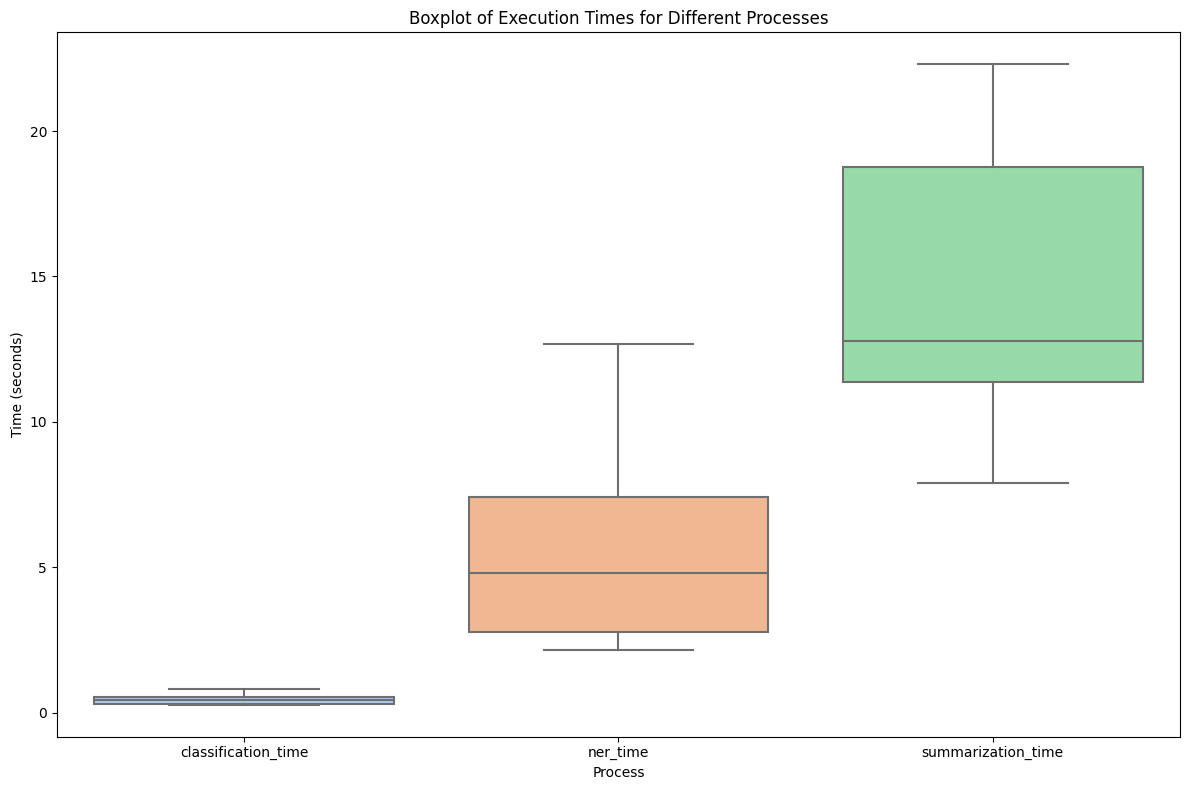

In [ ]:
sql = "SELECT * FROM execution_times"
conn = create_connection()
df = pd.read_sql(sql, con=conn)
conn.close()

# Melting the DataFrame to make it suitable for sns.boxplot
df_melted = df.melt(id_vars="article_id", var_name="Process", value_name="Time")

plt.figure(figsize=(12,8))
sns.boxplot(x="Process", y="Time", data=df_melted, palette="pastel")
plt.title('Boxplot of Execution Times for Different Processes')
plt.xlabel('Process')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()


Connection successful


<ipython-input-18-fa77d82b676e>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


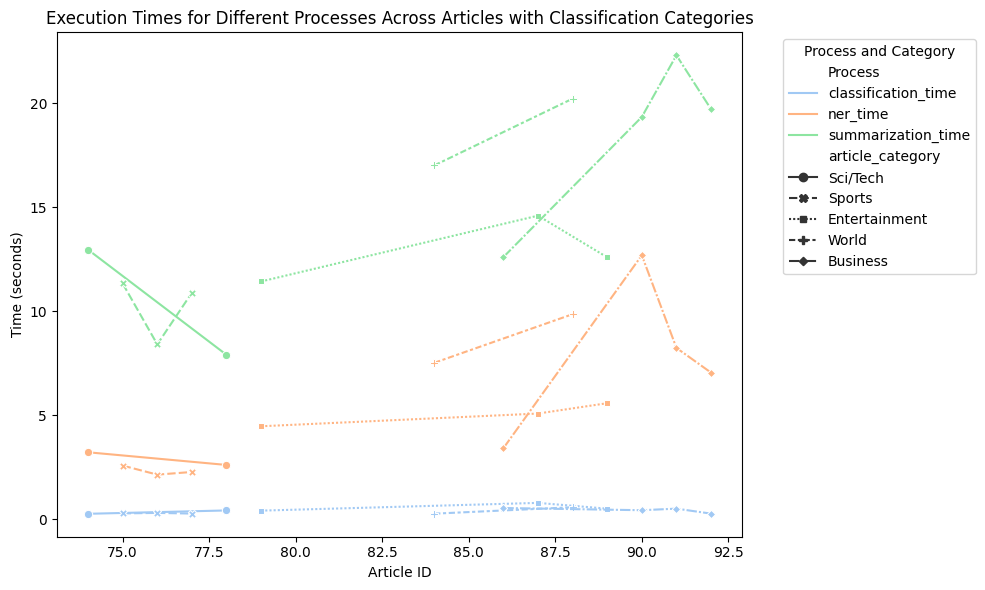

In [ ]:
sql = """
SELECT e.*, a.article_category
FROM execution_times e
JOIN article_category_and_summary a ON e.article_id = a.article_id
"""
conn = create_connection()
df = pd.read_sql(sql, con=conn)
conn.close()

# Melting the DataFrame to make it suitable for sns.lineplot
df_melted = df.melt(id_vars=["article_id", "article_category"], var_name="Process", value_name="Time")

plt.figure(figsize=(10,6))
sns.lineplot(x="article_id", y="Time", hue="Process", style="article_category", data=df_melted, palette="pastel", markers=True)
plt.title('Execution Times for Different Processes Across Articles with Classification Categories')
plt.xlabel('Article ID')
plt.ylabel('Time (seconds)')
plt.legend(title='Process and Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Connection successful


<ipython-input-19-3d351f607642>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


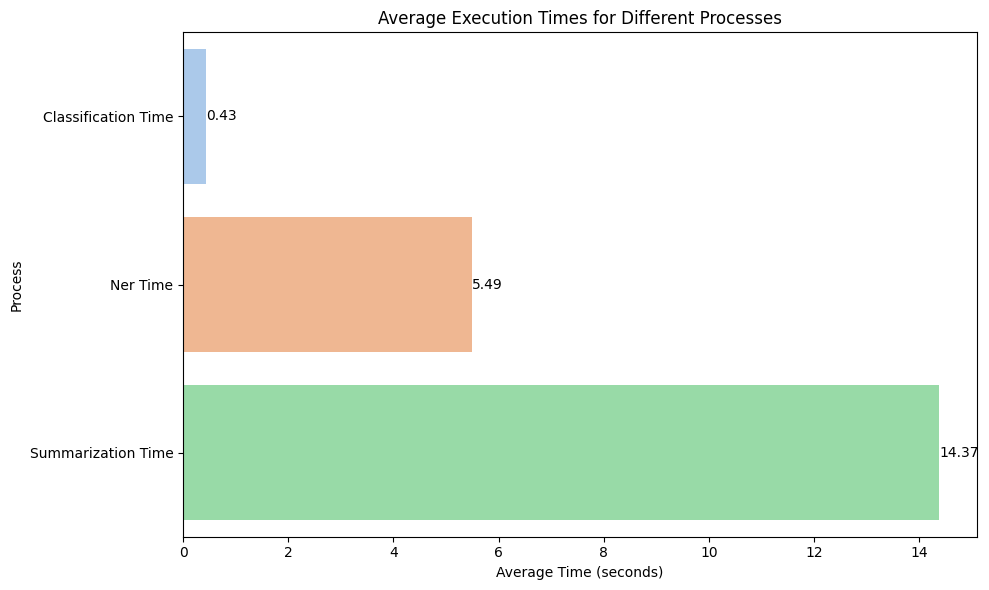

In [ ]:
sql = """
SELECT
    AVG(classification_time) as avg_classification_time,
    AVG(ner_time) as avg_ner_time,
    AVG(summarization_time) as avg_summarization_time
FROM execution_times;
"""
conn = create_connection()
df = pd.read_sql(sql, con=conn)
conn.close()

# Ensure the SQL query returned results
if df.empty:
    print("The query did not return any results. Please check your SQL query and database connection.")
else:
    # Transforming the DataFrame to make it suitable for visualizations
    df_melted = pd.melt(df, var_name="Process", value_name="Average Time")
    df_melted['Process'] = df_melted['Process'].str.replace('avg_', '').replace('_', ' ', regex=True).str.title()

# Creating a horizontal bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Average Time", y="Process", data=df_melted, palette="pastel")
ax.set(title='Average Execution Times for Different Processes', xlabel='Average Time (seconds)', ylabel='Process')

# Adding the values on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x-coordinate position of data label, padded 0.01 to right of bar
             p.get_y() + p.get_height() / 2,  # y-coordinate position of data label, to take vertical position to center of bar
             '{:1.2f}'.format(width),  # data label, formatted to ignore decimals
             va='center')  # sets vertical alignment (va) to center

plt.tight_layout()
plt.show()


Connection successful


<ipython-input-20-04685eeba808>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


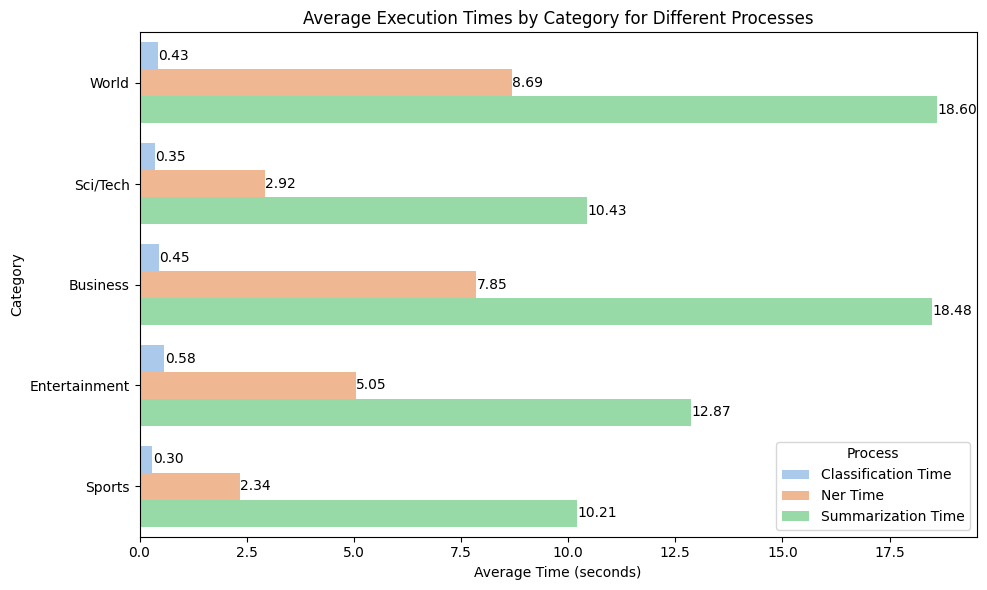

In [ ]:
sql = """
SELECT
    a.article_category,
    AVG(e.classification_time) as avg_classification_time,
    AVG(e.ner_time) as avg_ner_time,
    AVG(e.summarization_time) as avg_summarization_time
FROM execution_times e
JOIN article_category_and_summary a ON e.article_id = a.article_id
GROUP BY a.article_category;
"""

conn = create_connection()
df = pd.read_sql(sql, con=conn)
conn.close()

# Ensure the SQL query returned results
if df.empty:
    print("The query did not return any results. Please check your SQL query and database connection.")
else:
    # Transforming the DataFrame to make it suitable for visualizations
    df_melted = df.melt(id_vars="article_category", var_name="Process", value_name="Average Time")
    df_melted['Process'] = df_melted['Process'].str.replace('avg_', '').replace('_', ' ', regex=True).str.title()

# Creating a bar plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Average Time", y="article_category", hue="Process", data=df_melted, palette="pastel")
ax.set(title='Average Execution Times by Category for Different Processes', xlabel='Average Time (seconds)', ylabel='Category')

# Adding the values on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x-coordinate position of data label, padded 0.01 to right of bar
             p.get_y() + p.get_height() / 2,  # y-coordinate position of data label, to take vertical position to center of bar
             '{:1.2f}'.format(width),  # data label, formatted to ignore decimals
             va='center')  # sets vertical alignment (va) to center

plt.legend(title='Process')
plt.tight_layout()
plt.show()



## Data Visuals

In [ ]:
# import psycopg2

def create_connection():
    """Create and return a connection to the database"""
    conn_params = {
        "host": "news-db.cqxhphrjjndi.us-east-1.rds.amazonaws.com",
        "port": 5432,
        "user": "postgres",
        "password": "sjsu298postgres",
        "database": "newsDB"
    }
    try:
        conn = psycopg2.connect(**conn_params)
        print("Connection successful")
        return conn
    except Exception as e:
        print(f"Unable to connect to the database. Error: {e}")
        return None


Connection successful


<ipython-input-22-eb7addbcd1e7>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


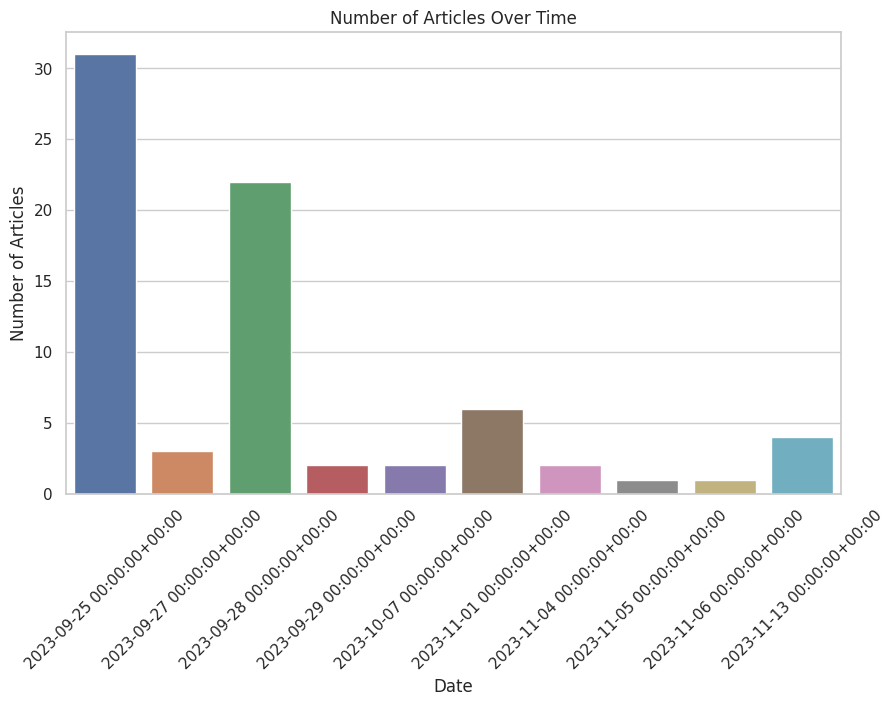

In [ ]:
# import pandas as pd
# import psycopg2
# import matplotlib.pyplot as plt
import seaborn as sns

# Establish the connection
conn = create_connection()

# SQL to fetch data
sql = "SELECT date_trunc('day', timestamp) as date, COUNT(*) as count FROM raw_article GROUP BY date ORDER BY date;"

# Fetching data into DataFrame
df = pd.read_sql(sql, con=conn)

# Close the connection
conn.close()

# Setting up the plot style
sns.set(style="whitegrid")

# Creating a bar plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x="date", y="count", data=df)
ax.set(xlabel='Date', ylabel='Number of Articles')
plt.xticks(rotation=45)
plt.title('Number of Articles Over Time')
plt.show()


Connection successful


<ipython-input-23-06b12d9b5135>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


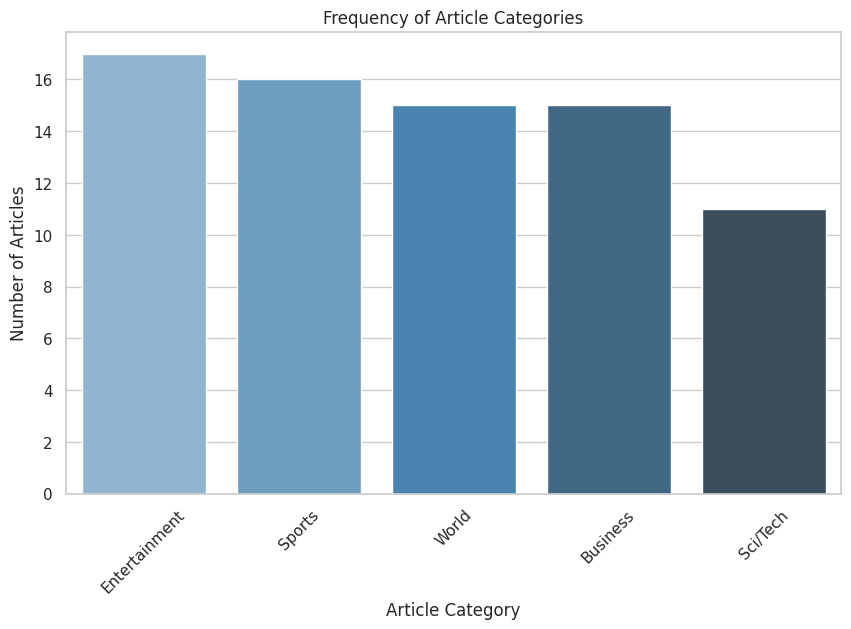

In [ ]:
# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with the query
if conn:
    # SQL to fetch data
    sql = """
    SELECT article_category, COUNT(*) as count
    FROM article_category_and_summary
    GROUP BY article_category
    ORDER BY count DESC;
    """

    try:
        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a vertical bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="article_category", y="count", data=df, palette="Blues_d")
        ax.set(xlabel='Article Category', ylabel='Number of Articles')
        plt.title('Frequency of Article Categories')
        plt.xticks(rotation=45)  # Optionally rotate the x-axis labels for better readability
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query: {e}")

    finally:
        # Close the connection
        conn.close()




Connection successful


<ipython-input-24-fd3b8cf6cde9>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


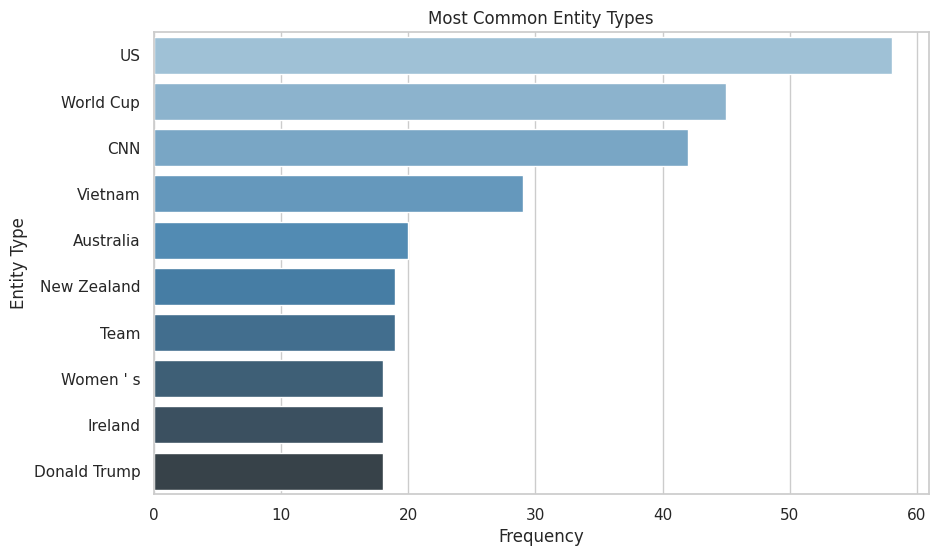

Connection closed


In [ ]:

# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with the query
if conn:
    # SQL to fetch data
    sql = "SELECT entity_type, COUNT(*) as count FROM article_ner GROUP BY entity_type ORDER BY count DESC LIMIT 10;"

    try:
        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="count", y="entity_type", data=df, palette="Blues_d")
        ax.set(xlabel='Frequency', ylabel='Entity Type')
        plt.title('Most Common Entity Types')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query: {e}")

    finally:
        # Close the connection
        conn.close()
        print("Connection closed")


Connection successful


<ipython-input-25-ac73ad9f452d>:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


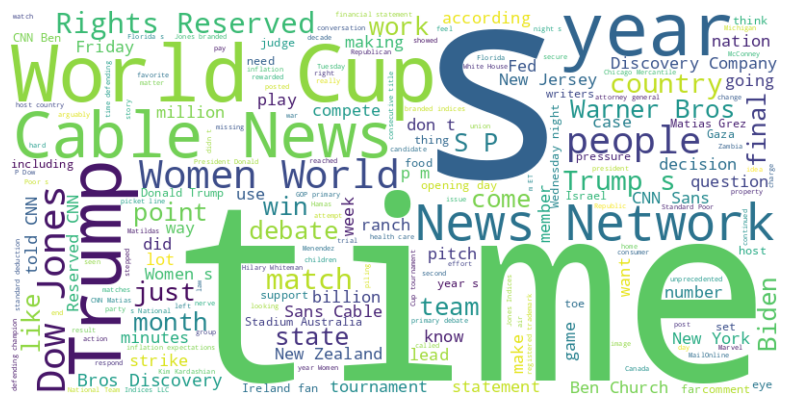

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import psycopg2
import pandas as pd

# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with fetching the contents and creating the Word Cloud
if conn:
    try:
        # SQL to fetch content data
        sql = "SELECT news_content FROM raw_article;"

        # Fetching content data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Concatenating the content column to form a single string
        text = ' '.join(df['news_content'].fillna('').values)

        # Define stop words
        stop_words = ENGLISH_STOP_WORDS.union(['said', 'say', 'says', 'will'])

        # Generate the word cloud
        wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)

        # Plotting the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query or generating the Word Cloud: {e}")

    finally:
        # Close the connection
        conn.close()


Connection successful


<ipython-input-26-21ab887064c1>:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=conn)


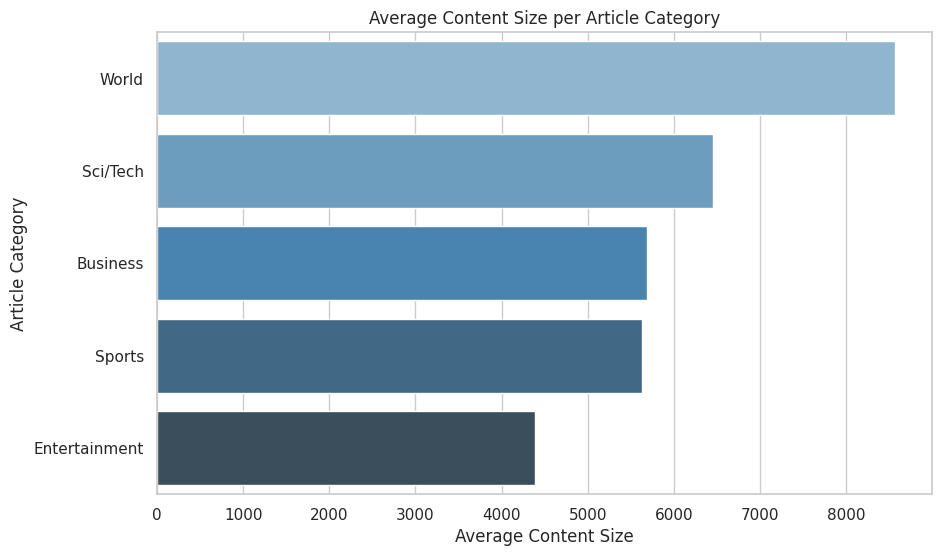

In [ ]:
# Establish the connection
conn = create_connection()

# If the connection was successful, proceed with fetching the data and creating the graph
if conn:
    try:
        # SQL to fetch data
        sql = """
        SELECT
            acs.article_category,
            AVG(LENGTH(ra.news_content)) as avg_content_size
        FROM raw_article ra
        JOIN article_category_and_summary acs ON ra.article_id = acs.article_id
        GROUP BY acs.article_category
        ORDER BY avg_content_size DESC;
        """

        # Fetching data into DataFrame
        df = pd.read_sql(sql, con=conn)

        # Setting up the plot style
        sns.set(style="whitegrid")

        # Creating a bar plot
        plt.figure(figsize=(10,6))
        ax = sns.barplot(x="avg_content_size", y="article_category", data=df, palette="Blues_d")
        ax.set(xlabel='Average Content Size', ylabel='Article Category')
        plt.title('Average Content Size per Article Category')
        plt.show()

    except Exception as e:
        print(f"An error occurred while executing the SQL query or creating the graph: {e}")

    finally:
        # Close the connection
        conn.close()
